In [78]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

from functools import cmp_to_key
from collections import Counter
%matplotlib inline

In [5]:
# Plot utilities
def plot_key_points(img, keypoints):
    """
    Input - 
            img - Source image
            keypoints - Keypoints of above image
    Returns - None
    
    Plot image by convert to color.
    """
    image_to_plot = cv2.drawKeypoints(img, keypoints, np.array([]))
    convert_and_plot(image_to_plot)
    
def convert_and_plot(img):
    """
    Input - Source image
    Returns - None
    
    Plots images after converting.
    """
    plt.rcParams["figure.figsize"] = [20, 20]
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [6]:
# Homography function
def get_homography(point_group_1, point_group_2, verbose=False):
    """
    Input - 
            point_group_[1 & 2] - 2 groups of points chosen randomly
            as a part of RANSAC
     
    Returns - Homography matrix
    """
    
    # Init P as None
    P = None
    
    # P matrix
    for point1, point2 in zip(point_group_1, point_group_2):
        # Get x, y & x', y'
        x, y = point1[0], point1[1]
        x_bar, y_bar = point2[0], point2[1] 
        
        point_matrix = [
            [x, y, 1, 0, 0, 0, -x * x_bar, -y * x_bar, -x_bar],
            [0, 0, 0, x, y, 1, -x * y_bar, -y * y_bar, -y_bar]
        ]
        # If this is the first pair of rows
        if P is None:
            P = np.array(point_matrix)
        # Or stack to exitsting
        else:
            P = np.vstack((P, point_matrix))
    
    # Get eigenvalues & eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(P.T.dot(P))
    
    # Get minimum eigenvalue's index
    min_eigenvalue_index = np.argmin(eigenvalues)
    
    # Sanity check - 1
    if verbose:
        print("Minimum eigenvalue found at ", min_eigenvalue_index, ":", eigenvalues[min_eigenvalue_index])
    
    # Get corresponding eigenvector
    min_eigenvector = eigenvectors[:, min_eigenvalue_index]
    
    # Normalize the eigenvector by L2 norm
    norm = np.linalg.norm(min_eigenvector)
    min_eigenvector /= norm
    
    # Sanity check - 2 
    # These values must be close to 0
    if verbose:
        print ("These values should be close to 0", np.round(P.dot(min_eigenvector), 2))
    
    # Homography matrix
    H = min_eigenvector.reshape(3, 3)
    
    # Sanity check - 3
    if verbose:
        for i, point in enumerate(point_group_1):
            point = [point[0], point[1], 1]
            point_2_predicted = np.dot(H, point)
            point_2_predicted = (point_2_predicted / point_2_predicted[-1])[:2]
            print("Original point:", point[:-1])
            print("Predicted point:", point_2_predicted)
            print("Actual point:", point_group_2[i])
            print()
    
    return H

In [8]:
# Matcher - based on descriptors
def kNN_matcher(des1, des2, k=2):
    """
    Input - 
            des1 & des2 - Descriptor matrices for 2 images
            k - Number of nearest neighbors to consider
    Returns - A vector of nearest neighbors of des1 & their indices for keypoints
    
    Mnemonic - des1 is like xtest, des2 is like xtrain
    """

    # Compute the L2 equations
    distances = np.sum(des1 ** 2, axis=1, keepdims=True) + np.sum(des2 ** 2, axis=1) - 2 * des1.dot(des2.T)
    distances = np.sqrt(distances)
    
    
    # Get smallest indices 
    min_indices = np.argsort(distances, axis=1)
    
    # Init ndarray 
    nearest_neighbors = []
    
    # Iter for nearest neighbors
    for i in range(min_indices.shape[0]):
        neighbors = min_indices[i][:k]
        curr_matches = []
        for j in range(len(neighbors)):
            match = cv2.DMatch(i, neighbors[j], 0, distances[i][neighbors[j]] * 1.)
            curr_matches.append(match)
        nearest_neighbors.append(curr_matches)
    
    return nearest_neighbors

def get_good_matches(matches, ratio_test_param=0.75):
    """
    Input - 
            matches - n x k matches from kNN_matcher
            ratio_test_param - Lowe's ratio test parameter
    """
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_test_param * n.distance:
            good_matches.append(m)
    return good_matches

In [158]:
def ransac(matches, kp1, kp2, epsilon=5.0, batch_size=4, max_iter=10, verbose=False):
    """
    Input - Matches from one_NN_matcher(..)
    Returns - Inlier homography matrix
    """    
    
    # Store best homography 
    best_H = None
    best_matches = []
    best_inilier_count = -1
        
    for curr_iter in range(max_iter):
        if verbose and (curr_iter + 1) % 5 == 0:
            print("Currently at iter #", (curr_iter +  1), sep="")
            
        # Randomly permute matches list
        np.random.shuffle(matches)
        
        # Iter through remaining matches
        for i in range(0, len(matches), batch_size):
            
            # Default termination condition
            if i + batch_size >= len(matches):
                break

            # Current random subsample
            point_group_1, point_group_2 = [], []
            for match in matches[i : i + batch_size]:
                point_group_1.append(kp1[match.queryIdx].pt)
                point_group_2.append(kp2[match.trainIdx].pt)

            # Compute Homography
            H = get_homography(point_group_1, point_group_2)

            # Initialize inlier Count
            inlier_count = 0

            # Get matches of current model
            curr_model_matches = []
            
            # Add inliers; remove outliers
            for m in matches:
                # Get left point
                point_1 = [kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1]
                
                # Get actual right point
                point_2_actual = [kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1]]

                # Predict right point
                point_2_predicted = np.dot(H, point_1)
                point_2_predicted = (point_2_predicted / point_2_predicted[-1])
                point_2_predicted = point_2_predicted[:-1]
                
                # Compute the L2 distances between predicted & actual point 
                diff = np.linalg.norm(np.subtract(point_2_actual, point_2_predicted))

                # Increment inlier_count if necessary
                if diff < epsilon:
                    inlier_count += 1
                    curr_model_matches.append(m)

            # Update best model if necessary
            if inlier_count > best_inilier_count:
                best_inilier_count = inlier_count
                best_H = H
                best_matches = curr_model_matches
                
                # Terminate early based on count
                if best_inilier_count > int(0.3 * len(kp1)):
                    if verbose:
                        print("-------------------\nCutting short early\n-------------------")
                        # Print stats and return best_H
                        print("Inliers -", best_inilier_count)
                        print("Outliers -", len(kp1) - best_inilier_count)
                    return best_H, best_matches
                    
    # Terminate normally with best_H seen
    if verbose:
        print("Inliers -", best_inilier_count)
        print("Outliers -", len(kp1) - best_inilier_count)
    return best_H, best_matches


def get_direction(kp1, kp2, des1, des2, img1, img2, verbose=True):
    """
    Input - 
            kp[1 & 2] - Keypoints from images 1 & 2
            des[1 & 2] - Descriptors from images 1 & 2
            img[1 & 2] - Imgaes 1 & 2
            
    Returns - Left & Right images
    """
    _, w, _ = img2.shape
    
    def get_distances(kp1, kp2, des1, des2):
        """
        Utility function to get left & right distances
        """
        matches = get_good_matches(kNN_matcher(des1, des2))
        _, matches = ransac(matches, kp1, kp2, max_iter=10)

        matches = sorted(matches, key=lambda x: x.distance)
#         convert_and_plot(cv2.drawMatches(img1, kp1, img2, kp2, matches, np.array([])))
        distances = []
        
        for match in matches:
            point1, point2 = kp1[match.queryIdx].pt, kp2[match.trainIdx].pt
            point1, point2 = np.array(point1), np.array(point2)

            point2[0] += w

            distance = np.linalg.norm(point1 - point2)
            distances.append(distance)
            
        return distances
        
    left_distances = get_distances(kp1, kp2, des1, des2)
    right_distances = get_distances(kp2, kp1, des2, des1)
    
#     print(np.mean(left_distances), np.mean(right_distances))
    if np.mean(left_distances) <= np.mean(right_distances):
        return -1
    return 1

2


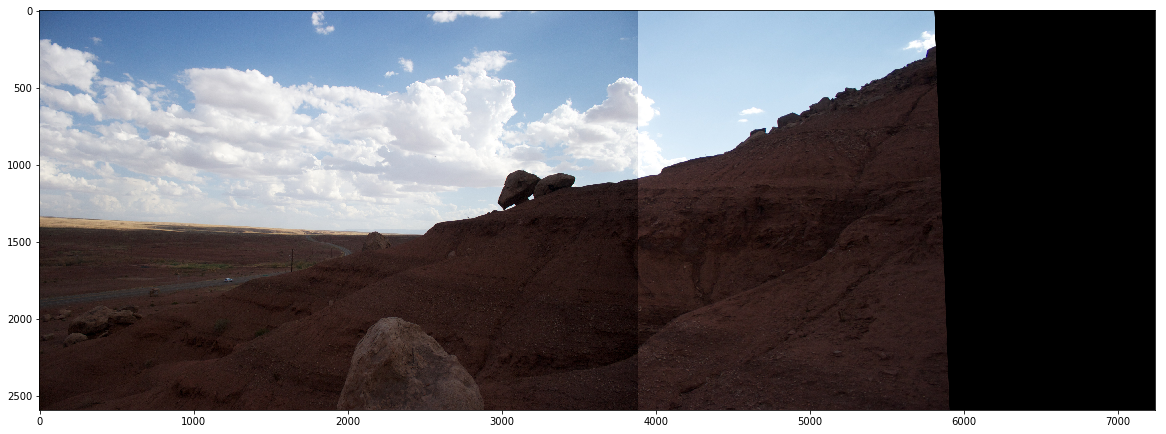

In [217]:
class Image:
    def __init__(self, img, kp, des):
        self.img = img
        self.kp = kp
        self.des = des
        
def stitch_images(path_to_directory, verbose=False):
    """
    Input - Path from images should be read from 
    Returns - None
    
    This function reads the images from the given
    path, aligns it and writes result into panaroma.jpg
    """
    # Get image paths in given directory
    image_paths = glob.glob(path_to_directory + "/*")
    
    # Read all these images with cv2.imread
    images = [cv2.imread(image_path)  for image_path in image_paths]
    
    # Image dimensions
    h, w, _ = images[0].shape
    
    # Convert each of these images to Image class
    for i, image in enumerate(images):
        keypoints, descriptors = sift.detectAndCompute(image, None)
        images[i] = Image(image, keypoints, descriptors)
    
    # Alignment step
    I = sorted(images, key=cmp_to_key(lambda x, y: get_direction(x.kp, y.kp, x.des, y.des, x.img, y.img)))

    # (in)Sanity check
    if verbose:
        convert_and_plot(I[0].img)
        convert_and_plot(I[1].img)
        if len(I) > 2:
            convert_and_plot(I[2].img)
    
    
    def stitch_2_images(I1, I2):
        """
        Utility function to stitch 2 images
        """
        matches = get_good_matches(kNN_matcher(I1.des, I2.des))
        H, matches = ransac(matches, I1.kp, I2.kp)
        
        H_inv = np.linalg.inv(H)
        H_inv /= H_inv[-1, -1]
        
        h, w, _ = I1.img.shape
        panaroma = cv2.warpPerspective(I2.img, H_inv, (w * 2, h))
        new_points = np.dot(H_inv, [h, w, 1])
        panaroma[:h, :w] = I1.img
        panaroma = panaroma[:, :int(w + new_points[1])]
        return panaroma
    
    assert(2 <= len(I) <= 3)

    if len(I) == 2:
        print(len(I))
        panaroma = stitch_2_images(I[0], I[1])
    else:
        # Merge Images 1 & 2
        dst = stitch_2_images(I[1], I[2])
        matches = get_good_matches(kNN_matcher(I[0].des, I[1].des))
        H_1_2, matches = ransac(matches, I[0].kp, I[1].kp)
        H_inv = np.linalg.inv(H_1_2)
        H_inv /= H_inv[-1, -1]
        new_points = np.dot(H_inv, [h, w, 1])
        panaroma = cv2.warpPerspective(dst, H_inv, (w * 3 , h))
        panaroma[:h, :w] = I[0].img
        panaroma = panaroma[:, :w + int(new_points[1])]
    
    convert_and_plot(panaroma)
    cv2.imwrite("panaroma.jpg", panaroma)
    
stitch_images("../data/nevada/", verbose=False)